In [ ]:
!git clone https://github.com/normankarr/CS194-Final-Project.git

Cloning into 'CS194-Final-Project'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 60 (delta 8), reused 60 (delta 8), pack-reused 0
Unpacking objects: 100% (60/60), done.


In [171]:
!unzip ./drive/MyDrive/datasets/gtFine_trainvaltest.zip -d ./CS194-Final-Project/data

unzip:  cannot find or open ./drive/MyDrive/datasets/gtFine_trainvaltest.zip, ./drive/MyDrive/datasets/gtFine_trainvaltest.zip.zip or ./drive/MyDrive/datasets/gtFine_trainvaltest.zip.ZIP.


In [ ]:
!unzip ./drive/MyDrive/datasets/leftImg8bit_trainvaltest.zip -d ./CS194-Final-Project/data

In [ ]:
cd CS194-Final-Project/

# Segmentation Code

In [116]:
import sys

import torch
import matplotlib.pyplot as plt

from data import cityscapes
from segmentation.trainer import Solver
from segmentation.models import fcn_resnet50, fcn_resnet18, fcn_resnet34

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
train_dataset = cityscapes.train_dataset(".")
val_dataset = cityscapes.val_dataset(".")
num_classes = len(train_dataset.classes)

In [124]:
train_loader = cityscapes.train_dataloader('./data', 32, num_workers=4, pin_memory=True)
val_loader = cityscapes.val_dataloader('./data', 32, num_workers=4, pin_memory=True)

In [ ]:
model = fcn_resnet34(num_classes)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
solver = Solver("resnet18", model, train_loader, val_loader, device)

In [ ]:
train_history, val_history = solver.train(criterion, optimizer)

Training 100.00%: Loss 1.94627
Epoch 0 Completed in 189.20 Seconds
Training Loss: 1.92534 Validation Loss: 1.12470
load time:  138.07295656204224
loss time:  15.314365863800049
Training 100.00%: Loss 0.92692
Epoch 1 Completed in 183.34 Seconds
Training Loss: 0.91695 Validation Loss: 0.87777
load time:  133.3554711341858
loss time:  15.167289733886719
Training 100.00%: Loss 0.78126
Epoch 2 Completed in 183.01 Seconds
Training Loss: 0.77286 Validation Loss: 0.79701
load time:  132.7710199356079
loss time:  15.063499689102173
Training 100.00%: Loss 0.71777
Epoch 3 Completed in 182.57 Seconds
Training Loss: 0.71005 Validation Loss: 0.75987
load time:  132.45377135276794
loss time:  15.082485914230347
Training 100.00%: Loss 0.67518
Epoch 4 Completed in 182.72 Seconds
Training Loss: 0.66792 Validation Loss: 0.72919
load time:  132.83908891677856
loss time:  15.277303695678711
Training 100.00%: Loss 0.65163
Epoch 5 Completed in 182.92 Seconds
Training Loss: 0.64462 Validation Loss: 0.72532
lo

In [ ]:
checkpoint = {'state_dict': model.state_dict(),'optimizer' :optimizer.state_dict()}
torch.save(checkpoint, 'segmentation/modelsfnc_resnet34_ckpt.pth')

In [121]:
checkpoint = torch.load("segmentation/models/fcn_resnet34_ckpt.pth")
state_dict = checkpoint["state_dict"]
model = fcn_resnet34(35)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [133]:
import time
start = time.time()
imgs, targets = next(iter(train_loader)) #change to val_loader to visualize validation data
end = time.time()
print(end - start)

13.131805896759033


In [134]:
scores = model(imgs)

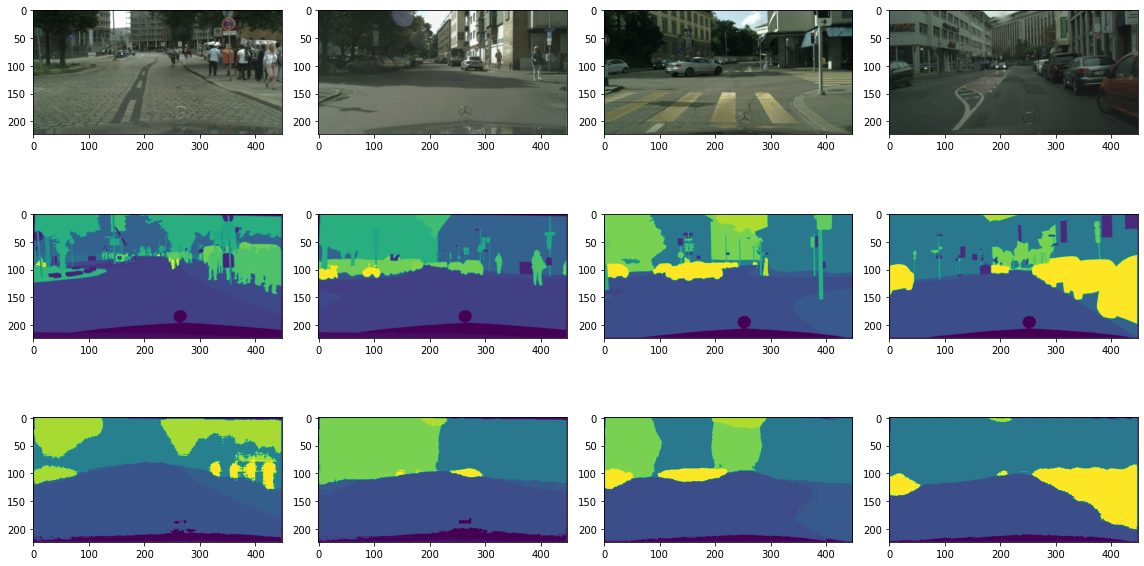

In [140]:
fig, (row0, row1, row2) = plt.subplots(3,4, figsize=(16,9))

means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]
for i in range(4):
  img = imgs[i].permute(1,2,0)

  for j in range(3):
    img[:,:,j] = img[:,:,j] * stds[j] + means[j]

  row0[i].imshow(img)
  row1[i].imshow(targets[i])
  row2[i].imshow(torch.argmax(scores, 1)[i])

#plt.colorbar()
plt.tight_layout()
plt.show()

In [145]:
targets[1][100,110]

tensor(30)

# Predict labels for test data

In [ ]:
import os
from PIL import Image
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
checkpoint = torch.load("models/fcn_resnet34_ckpt.pth")
state_dict = checkpoint["state_dict"]
model = fcn_resnet34(35)
model.load_state_dict(state_dict)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
test_img_dir = "data/leftImg8bit/test"
target_img_dir = "data/gtFine/test"

In [ ]:
img_transforms = []
img_transforms.append(transforms.Resize(224))
img_transforms.append(transforms.PILToTensor())
img_transforms.append(transforms.ConvertImageDtype(torch.float))
img_transforms.append(transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)))
img_transforms = transforms.Compose(img_transforms)

In [ ]:
device = device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
toPil = transforms.ToPILImage()

In [ ]:
# Original image shape: 1024, 2048
i = 0
for city in os.listdir(test_img_dir):
  img_dir = os.path.join(test_img_dir, city)
  target_dir = os.path.join(target_img_dir, city)
  for file_name in os.listdir(img_dir):
    print("\r "+str(i),end="")
    img_path = os.path.join(img_dir, file_name)
    img = Image.open(img_path).convert('RGB')
    img = img_transforms(img)
    (c, h, w) = img.shape
    img = img.reshape((1, c, h, w))
    img = img.to(device)
    with torch.no_grad():
      scores = model(img)
    sgmt = torch.argmax(scores, 1)
    sgmt = transforms.functional.resize(sgmt, [1024, 2048]).cpu().type(torch.int32)
    sgmt = toPil(sgmt)
    #sgmt = transforms.functional.to_pil_image(sgmt.type(torch.int32))
    save_path = target_dir+"/"+file_name[:-15]+"gtFine_labelIds.png"
    sgmt.save(save_path)
    i+=1

 1524

In [ ]:
# change file permisions
i = 0
test_sgmt_dir = "../data/gtFine/test/"
for city in os.listdir(test_sgmt_dir):
  img_dir = os.path.join(test_sgmt_dir, city)
  for file_name in os.listdir(img_dir):
    sgmt_path = os.path.join(img_dir, file_name)
    os.chmod(sgmt_path, 0o644)

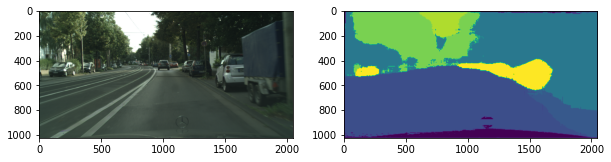

In [ ]:
ex_sgmt = Image.open("/data/gtFine/test/berlin/berlin_000000_000019_gtFine_labelIds.png")
ex_img = Image.open("/data/leftImg8bit/test/berlin/berlin_000000_000019_leftImg8bit.png")
ex_sgmt = transforms.PILToTensor()(ex_sgmt)
ex_img = transforms.PILToTensor()(ex_img)

fix, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.imshow(ex_img.permute(1,2,0))
ax2.imshow(ex_sgmt[0])
plt.show()

# Spade code

In [ ]:
cd spade

/content/CS194-Final-Project/spade


In [ ]:
pip install -r requirements.txt

In [ ]:
!python3 test.py --name cityscapes_pretrained --dataset_mode cityscapes --dataroot ../data --phase test --batchSize 2 --load_size 224 --crop_size 224


----------------- Options ---------------
             aspect_ratio: 2.0                           
                batchSize: 2                             	[default: 16]
      cache_filelist_read: False                         
     cache_filelist_write: False                         
          checkpoints_dir: ./checkpoints                 
   contain_dontcare_label: False                         
                crop_size: 224                           	[default: 512]
                 dataroot: ../data                       	[default: ./datasets/cityscapes/]
             dataset_mode: cityscapes                    	[default: coco]
          display_winsize: 512                           
                  gpu_ids: 0                             
                 how_many: inf                           
                init_type: xavier                        
            init_variance: 0.02                          
                  isTrain: False                         	[default:

In [ ]:
!zip -r "results.zip" "results/cityscapes_pretrained/test_latest"

In [ ]:
pwd

'/content/CS194-Final-Project/spade'

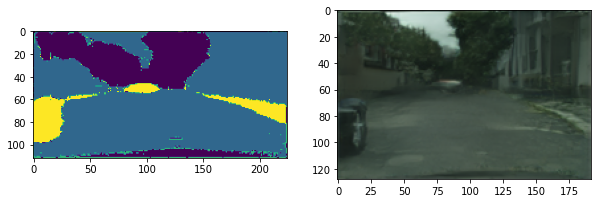

In [ ]:
# Visualize an example
ex_sgmt = Image.open("./results/cityscapes_pretrained/test_latest/images/input_label/berlin_000000_000019_leftImg8bit.png")
synt_img = Image.open("./results/cityscapes_pretrained/test_latest/images/synthesized_image/berlin_000000_000019_leftImg8bit.png")

ex_sgmt = transforms.PILToTensor()(ex_sgmt)
synt_img = transforms.PILToTensor()(synt_img)

fix, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.imshow(ex_sgmt[0])
ax2.imshow(synt_img.permute(1,2,0))
plt.show()

# Feed Generated Images Back into Segmentation Model

In [ ]:
# Note that file organization needs to be done to shape the output of results
# to have the same format as cityscapes

In [3]:
cd CS194-Final-Project

/content/CS194-Final-Project


In [8]:
import sys
import os

import torch
import matplotlib.pyplot as plt

from data import cityscapes
from segmentation.models import fcn_resnet34

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
checkpoint = torch.load("segmentation/models/fcn_resnet34_ckpt.pth")
state_dict = checkpoint["state_dict"]
model = fcn_resnet34(35)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [32]:
synthetic_dataloader = cityscapes.test_dataloader("./spade/results/cityscapes_pretrained", 4)
synthetic_iter = iter(synthetic_dataloader)
synt_img, sgmt = next(synthetic_iter)

In [33]:
scores = model(synt_img)

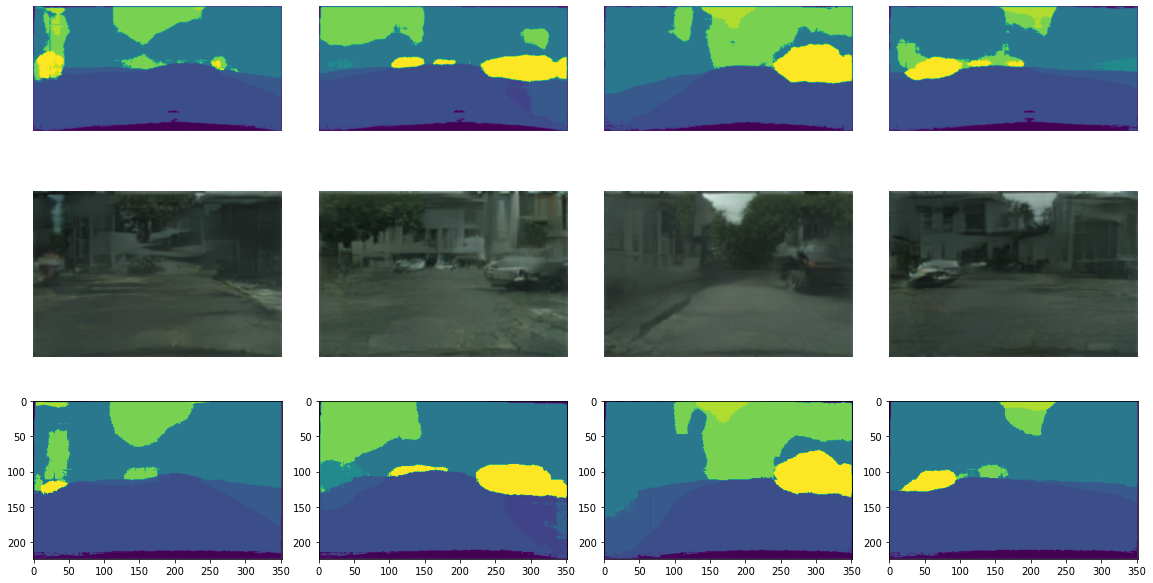

In [36]:
fig, (row0, row1, row2) = plt.subplots(3,4, figsize=(16,9))

means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]
for i in range(4):
  img = synt_img[i].permute(1,2,0)

  #for j in range(3):
    #img[:,:,j] = img[:,:,j] * stds[j] + means[j]

  row0[i].imshow(sgmt[i])
  row1[i].imshow(img)
  row2[i].imshow(torch.argmax(scores, 1)[i])

  row0[i].axis('off')
  row1[i].axis('off')

plt.tight_layout()
plt.show()